In [1]:
import pandas as pd
import numpy as np
import pickle
import statsmodels.api as sm
from sklearn import metrics

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

In [2]:
# Dla bazy danych heart
df_o = pd.read_csv("data/heart.csv")
print(df_o.shape)
df_o.head()
target = "TenYearCHD"
numFeatures = ['age', 'totChol', 'cigsPerDay', 'diaBP',' sysBP', 'BMI', 'heartRate', 'glucose']
catFeatures = [ 'male', 'education', 'currentSmoker',  'BPMeds', 'prevalentStroke', 'prevalentHyp',  'diabetes']

(3656, 16)


In [6]:
# Dla bazy danych alt
df_o = pd.read_csv("data/ver3.csv")
print(df_o.shape)
df_o.head()
target = "TenYearCHD"
numFeatures = ['age', 'log_totChol','log_sysBP', 'log_BMI', 'heartRate', 'log_glucose']
catFeatures = [ 'male', 'education', 'currentSmoker', 'prevalentHyp']

(3603, 11)


In [7]:
from sklearn import preprocessing

In [8]:
# Kopiowanie obiektu
df = df_o.copy()
# Słownik zawierachąch mapy
mapy = {}
for feature in catFeatures:
    # Iniciujemy obiekt do kodowania, który będzie przechowywał mapę
    le = preprocessing.LabelEncoder()
    # Dopasowujemy kolumnę (tworzymy mapę) i od razu ją nakładamy na zmienną, na której robiliśmy dopasowanie
    df[feature] = le.fit_transform(df_o[feature])
    # Zapiszmy mapę, aby móc odzyskać informację o mapowaniu i oryginalnych wartościach
    mapy[feature] = le

In [9]:
features = df.columns.tolist()
features.remove(target)
#print(features)

In [10]:
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score


# Przygotujmy wrapper
def CVTestRFClass(nFolds = 5, randomState=2020, debug=False, features=features, *args, **kwargs):
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # listy do przechowywania wyników:
    testResults = []
    trainResults = []
    predictions = []
    indices = []

    # Pętla walidująca model na kolejnych foldach
    for train, test in kf.split(df.index.values):
        # Przygotowanie estymatora
        clf = RandomForestClassifier(*args, **kwargs, random_state=randomState, n_jobs=-1)
        if debug:
            print(clf)
        # Trenowanie modelu
        clf.fit(df.iloc[train][features], df.iloc[train][target])

        # Przygotowanie prognoz dla zbioru treningowego i testowego
        # UWAGA Sklearn zwracał będzie dwie kolumny prawdopodobieństw dla obydwu klas
        predsTrain = clf.predict_proba(df.iloc[train][features])[:,1]
        preds = clf.predict_proba(df.iloc[test][features])[:,1]
        
        # Zachowajmy informacje o predykcjach dla tego foldu
        predictions.append(preds.tolist().copy())
        
        # Razem z indeksami w oryginalnym data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # Policzenie dopasowania za pomocą metryki ROC-AUC
        trainScore = roc_auc_score((df[target].iloc[train]==1).astype(int), predsTrain)
        testScore = roc_auc_score((df[target].iloc[test]==1).astype(int), preds)
        
        # Zapisanie wyników do listy 
        trainResults.append(trainScore)
        testResults.append(testScore)
        
        # Informowanie o każdym foldzie razem z wynikami treningowymi możemy opcjonalnie wyświetlać w trakcie
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
        
    return trainResults, testResults, predictions, indices

In [11]:
trainResults, testResults, predictions, indices = CVTestRFClass(debug=True)
print(np.mean(testResults))

RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.6914434311769735
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9999999999999999 Valid AUC: 0.7298550724637681
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.7007326892109501
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.6740927057132591
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 1.0 Valid AUC: 0.7132849924535731
0.7018817782037049


In [12]:
# Pętla po parametrze n_estimators
for k in [10, 25, 50, 100, 200, 500, 1000, 2000, 5000]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

10 0.9994889252941077 0.6602780765987336 0.3392108486953741
25 0.99998301979115 0.6858014402558344 0.31418157953531556
50 1.0 0.6948295907987545 0.3051704092012455
100 1.0 0.7018817782037049 0.2981182217962951
200 1.0 0.7001826022047163 0.2998173977952837
500 1.0 0.7013565615106288 0.29864343848937125
1000 1.0 0.7025725571904871 0.29742744280951294
2000 1.0 0.7025237913084181 0.29747620869158187
5000 1.0 0.7024647231368986 0.29753527686310144


Im więcej drzew tym lepiej. Brak dużej poprawy na wysokości 1000 drzew (a wręcz pogorszenie, wynika to z losowości). Zostawiamy 1000 drzew.

In [13]:
for k in range(2,22,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.7310263922024982 0.705754439630509 0.02527195257198922
4 0.7783023252848434 0.7132147405202323 0.06508758476461118
6 0.8535335687610779 0.7135870772278834 0.1399464915331945
8 0.9408878699126099 0.7137812928051963 0.22710657710741355
10 0.9909617500602399 0.7085910856254731 0.28237066443476677
12 0.9997809402522513 0.7061555977376138 0.29362534251463746
14 1.0 0.7046022941859389 0.2953977058140611
16 1.0 0.7003397480868021 0.2996602519131979
18 1.0 0.7008370117804847 0.29916298821951526
20 1.0 0.7007079704184418 0.2992920295815582


Szybkie przetrenowanie. Różnica gwałtownie rośnie wraz ze wzrostem głębokości. Dla 4 wydaje się najlepiej.

In [14]:
for k in range(2, len(features) + 1,2):
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=4,
                                                                    max_features=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.7766354370931996 0.7127590012536856 0.06387643583951397
4 0.7785347882358457 0.712771401981175 0.06576338625467071
6 0.7795613694326491 0.7130503918141256 0.06651097761852354
8 0.779499419240561 0.7123761655049654 0.06712325373559558
10 0.7799282046725768 0.712567930662378 0.06736027401019884


Najlepsze dla 6 zmiennych.

In [21]:
for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=4,
                                                                    max_features=6,
                                                                    min_samples_split=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

2 0.7795613694326491 0.7130503918141256 0.06651097761852354
4 0.7793314430207527 0.7132694925581199 0.06606195046263286
6 0.7786761757237051 0.7133159624264318 0.06536021329727326
8 0.7780125218919396 0.7130783063834675 0.06493421550847212
10 0.7774777957338893 0.7131339495353874 0.06434384619850186
15 0.7763134013149268 0.7130339535065549 0.06327944780837191
20 0.7754703845609814 0.7129834238980461 0.06248696066293524
30 0.7740436407506899 0.7132039491357454 0.06083969161494451


Niewielkie różnice, raczej kwestia losowosci. Wybieram 6.

In [25]:
for k in [1, 2, 4, 8, 10, 20, 30, 50 ,60]:
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=4,
                                                                    max_features=6,
                                                                    min_samples_split=6, min_samples_leaf=k)
    print(k, np.mean(trainResults), np.mean(testResults), np.mean(trainResults) - np.mean(testResults))

1 0.7786761757237051 0.7133159624264318 0.06536021329727326
2 0.7795115219993953 0.7135815205738878 0.06593000142550753
4 0.7793589204892999 0.7133851273388799 0.06597379315041996
8 0.7772566882477812 0.7126216067562688 0.06463508149151231
10 0.7763281677143745 0.7122984255914964 0.06402974212287815
20 0.7716795515902193 0.7133742528985133 0.058305298691705976
30 0.7679598176688751 0.7140703556515859 0.05388946201728917
50 0.7616106676811434 0.7150041013299606 0.046606566351182765
60 0.7586937352011096 0.7150547436034659 0.04363899159764373


Najpierw spada, pozniej rosnie. Wybieram 50.

In [26]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=4,
                                                                    max_features=6,
                                                                    min_samples_split=6, min_samples_leaf=50)
print(np.mean(testResults))

modelRF = {
    "name":"RF",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=500, max_depth=20, max_features=4, min_samples_split=4, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.7150041013299606


Poprawa z 0.701 na 0.715

In [27]:
import pickle

# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_RF_1_ver3.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF, fp)

---

In [34]:
# Przygotujmy listę do zapisywnia wyników
results = []

In [35]:
import random
# Teraz napiszmy pętle, w której będziemy iterować kolejne wyszukiwania.
for k in range(50):
    # Przygotujmy słownik parametrów
    # Jako punkt odniesienia do wybranych przedziałów posłużą nam wcześniejsze wyniki
    params = {
        "max_depth" : random.randint(7, 18),
        "max_features" : random.randint(2, 10),
        "min_samples_split" : random.randint(2, 15),
    }
    # Wartość min_samples_leaf musi być mniejsza niż min_samples_split
    params["min_samples_leaf"] = random.randint(1, params["min_samples_split"])
    
    # Estymacja modelu dla wylosowanych hiperparametrów
    trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=100,
                                                                    max_depth=params["max_depth"],
                                                                    max_features=params["max_features"],
                                                                    min_samples_split=params["min_samples_split"],
                                                                    min_samples_leaf=params["min_samples_leaf"])
    
    # Zapiszmy wynik
    results.append((np.mean(testResults), params.copy()))
    
    # Wyświetlmy wynik bieżącej iteracji
    print(params, np.mean(testResults))
    
    # Co 10 iteracji wyświetlmy sobie nasze dotychczasowe top 5
    if k>1 and k%10==0:    
        print("\n Top 5:")
        for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:5]:
            print(params, score)
        print()

{'max_depth': 14, 'max_features': 6, 'min_samples_split': 3, 'min_samples_leaf': 2} 0.7007722235420273
{'max_depth': 18, 'max_features': 2, 'min_samples_split': 14, 'min_samples_leaf': 11} 0.7135711790703368
{'max_depth': 12, 'max_features': 3, 'min_samples_split': 14, 'min_samples_leaf': 5} 0.7126357684406128
{'max_depth': 18, 'max_features': 10, 'min_samples_split': 13, 'min_samples_leaf': 9} 0.7000634388771548
{'max_depth': 10, 'max_features': 6, 'min_samples_split': 6, 'min_samples_leaf': 5} 0.7057289394569443
{'max_depth': 8, 'max_features': 3, 'min_samples_split': 6, 'min_samples_leaf': 6} 0.7111595263756032
{'max_depth': 9, 'max_features': 5, 'min_samples_split': 8, 'min_samples_leaf': 1} 0.7072766415011337
{'max_depth': 8, 'max_features': 8, 'min_samples_split': 6, 'min_samples_leaf': 5} 0.7066549333623827
{'max_depth': 13, 'max_features': 4, 'min_samples_split': 14, 'min_samples_leaf': 4} 0.7094086117684361
{'max_depth': 8, 'max_features': 2, 'min_samples_split': 10, 'min_samp

In [38]:
for score, params in sorted(results, key=lambda x: x[0], reverse=True)[0:1]:
            print(params, score)

{'max_depth': 8, 'max_features': 2, 'min_samples_split': 10, 'min_samples_leaf': 3} 0.7145825112125186


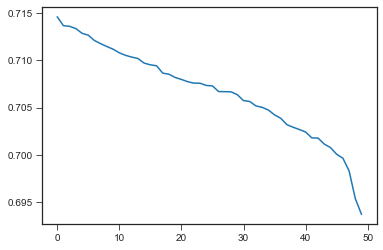

In [36]:
# Zobaczmy jak wyglądają wyniki od najlepszego graficznie
plt.plot([x for x, y in sorted(results, key=lambda x: x[0], reverse=True)])

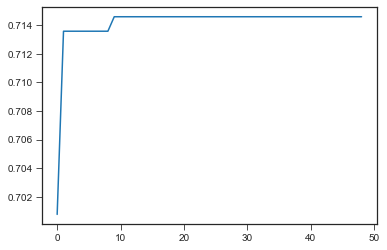

In [37]:
# Możemy tez zobaczyć jak z czasem poprawiał się najlepszy wynik:
bestHistory = []
for k in range(1,len(results)):
    # List comprehension: dla k pierwszych wartości zwróć maximum
    bestHistory.append(np.max([x for x, y in sorted(results[:k], key=lambda x: x[0], reverse=True)]))
# Wykres historii
plt.plot(bestHistory)

Zapisuję wyniki

In [41]:
trainResults, testResults, predictions, indices = CVTestRFClass(n_estimators=1000, max_depth=8,
                                                                    max_features=2,
                                                                    min_samples_split=10, min_samples_leaf=3)
print(np.mean(testResults))

modelRF_rs = {
    "name":"RF_rs",
    "description":"Model RF, ze zmiennymi kategorycznymi z LE",
    "specification":'n_estimators=500, max_depth=20, max_features=4, min_samples_split=4, min_samples_leaf=1',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.7147446648387723


In [42]:
# Otwieramy plik do zapisu binarnego z wykorzystenim with
with open("model_RF_1_ver3_rs.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF_rs, fp)